# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №5 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 15 декабря 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 декабря, -4 балла после 06:00 24 декабря, -6 баллов после 06:00 31 декабря -8 баллов  после 06:00 7 января


Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (6 баллов)

###### Боевое применение (2 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

# Определяем, что вам досталось

Укажите свою фамилию на русском языке в поле ниже.

In [32]:
import hashlib

def lucky_hash(text):
    return int(hashlib.md5(text.encode('utf-8')).hexdigest()[:8], 16) 

USER_NAME = u"Мaкин".lower()

ALGORITHMS = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - число кластеров)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - число кластеров, linkage)",]

print ("Имплементируйте алгоритм кластеризации %s"\
% (
    ALGORITHMS[lucky_hash(USER_NAME[::-1]) % 2]
) )

Имплементируйте алгоритм кластеризации Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - число кластеров)


Не стоит переживать из-за Вашего варианта. Технически оба алгоритма несложно реализовать.  EM алгоритма бояться не стоит, Вам будет нужно просто реализовать уже выведенные формулы для E и M шагов.

In [514]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [512]:
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [515]:
from scipy.stats import multivariate_normal

# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать один из двух популярных методов кластеризации: разделение смеси нормальных распределений или агломеративную кластеризацию. 

## Смесь нормальных распределений



Предполагаем, что наши данные порождены смесью $k$ нормальных распределений, то есть 

$$ p(\mathbf{x}) = \sum_k \pi_k \mathcal{N}(\mathbf{x} | \mathbf{\mu}_k, \mathbf{\Sigma}_k) $$,


где $\mathcal{N}$ - многомерное нормальное распределение размерности ${D}$:

$$\mathcal{N(\mathbf{x} | \mathbf{\mu}, \mathbf{\Sigma}}) = \frac{1}{(2 \pi)^{D/2}} \frac{1}{|\mathbf{\Sigma}|^{1/2}} \exp \left\{-\frac{1}{2}(\mathbf{x} - \mathbf{\mu})^T \mathbf{\Sigma^{-1}} (\mathbf{x} - \mathbf{\mu})\right\}$$

**Параметры**  


${D}$-мерный вектор средних

$$\mathbf{\mu}$$

$D \times D$-мерная матрица ковариации   (симметричная)


$$\mathbf{\Sigma} = E[(\mathbf{x} - \mathbf{\mu})(\mathbf{x} - \mathbf{\mu})^T]$$



Необходимо оценить параметры $\pi_k, \mathbf{\mu_k}, \mathbf{\Sigma_k} $ для всех компонент смеси.  Сделать это можно с помощью EM алгоритма - алгоритма, который находит оценку максимального правдоподобия в задаче со скрытыми переменными. 

## Expectation Maximization

**I** До цикла проинциализировать случайно  $\mu_k, \Sigma_k, \pi_k$ ($\pi_k$ должны суммироваться в 1)

**E** Expectation: при фиксированных $\mu_k, \Sigma_k, \pi_k$
$$
p(z_k = 1| x_n ) = \gamma(z_{nk}) = \frac{\pi_k \mathcal{N} (\mathbf{x}_n | \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N} (\mathbf{x}_n | \mu_j, \Sigma_j)}
$$
**M** Maximization: при фиксированных $\gamma(z_{nk})$
$$
N_k = \sum_{n=1}^N \gamma(z_{nk}), \;\; \mu_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) \mathbf{x}_n
$$
$$
\Sigma_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) (\mathbf{x}_n - \mu_k)(\mathbf{x}_n - \mu_k)^T
$$
$$
\pi_k = \frac{N_k}{N}
$$
**S** Остановиться при достижении сходимости

Номер кластера для $n$ объекта будем брать по принципу maximum a-posteriori, то есть относить объект к тому кластеру, у которого максимальна апостериорная вероятность:
$$ k_n =  \arg\underset{k}\max  p(z_k = 1| x_n ) =  \arg\underset{k}\max \gamma(z_{nk}) $$

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Для простоты будем использовать евклидово расстояние между объектами.



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

***Задача 1. Сходимость kmeans.***

Метод kmeans является частным случаем EM алгоритма и наиболее простым в обосновании сходимости. Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



***Ваше решение здесь***

Алгоритм k-means минимизирует следующий функционал:

$$ J = \sum_{i=1}^{K} \sum_{x \in C_i} \left\lVert x - \mu_i \right\rVert^2 $$

т.е. минимизируется сумма квадратов отклонений точек от центров кластеров.

Всего у нас $K$ - кластеров, каждый объект (всего объектов $N$) может принадлежать одному из них, а значит всевозможных разбиений $N$ объектов на $K$ кластеров - $K^N$ штук. 

Используем теорему Вейерштрасса:  
> Теорема Вейерштрасса об ограниченной сверху возрастающей последовательности утверждает, что любая ограниченная сверху монотонно возрастающая последовательность имеет предел, причем этот предел равен её точной верхней (или нижней) грани.

Функционал квадратичный, а значит существует только один локальный минимум (он же глобальный). На каждой итерации алгоритма происходит новый выбор центров кластеров, получаем каждый раз новое разбиение объектов на кластера, причем каждое новое разбиение зависит от старого, и значение функционала каждый раз не возрастает, т.е получается что на каждой итерации мы либо уменьшаем значение функционала, либо достигаем минимума (алгоритм завершен), а значит по теореме Вейерштрасса существует сходимость, и алгоритм отработает не более чем за $K^N$ шагов.

***Задача 2. Сходимость EM.***

Разобравшись со сходимостью kmeans, можно догадаться и до ответа про EM алгоритм.

При каком условии на правдоподобие системы EM алгоритм будет  сходиться?



***Ваше решение здесь***

* EM-алгоритм на каждом шаге неуменьшает правдоподобие системы, а значит для сходимости нужно, чтобы правдоподобие системы было ограничено.

***Задача 3. Формулы Ланса-Вильямса.***

Формулы Ланса-Вильямса крайне удобны для быстрого пересчета расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Ваше решение здесь***

* 1)

Докажем вначале, что $ min(a,\,b) = \frac{1}{2} a + \frac{1}{2} b - \frac{1}{2} \left| a - b \right| (*)$ 

$$\begin{matrix} min(a,\,b) = b = \frac{1}{2} a + \frac{1}{2} b - \frac{1}{2} (a - b), a >= b \\ min(a,\,b) = a = \frac{1}{2} a + \frac{1}{2} b + \frac{1}{2}(a - b), a <= b \end{matrix}$$

Или просто можно записать

$$ min(a,\,b) = \frac{1}{2} a + \frac{1}{2} b - \frac{1}{2} \left| a - b \right| $$
Также, очевидно, что:
$$ d_{min} (U \cup V,\,S) = min(d_{min}(U,\,S),\, d_{min}(V,\,S)) $$

Тогда используя $(*)$, получаем:
$$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $$

ч.т.д.

* 2)

Докажем вначале, что $ max(a,\,b) = \frac{1}{2} a + \frac{1}{2} b + \frac{1}{2} \left| a - b \right| (**)$ 

$$\begin{matrix} max(a,\,b) = a = \frac{1}{2} a + \frac{1}{2} b + \frac{1}{2} (a - b), a >= b \\ max(a,\,b) = b = \frac{1}{2} a + \frac{1}{2} b - \frac{1}{2}(a - b), a <= b \end{matrix}$$

Или просто можно записать

$$ max(a,\,b) = \frac{1}{2} a + \frac{1}{2} b + \frac{1}{2} \left| a - b \right| $$
Также, очевидно, что:
$$ d_{max} (U \cup V,\,S) = max(d_{max}(U,\,S),\, d_{max}(V,\,S)) $$

Тогда используя $(**)$, получаем:
$$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $$
ч.т.д.


# Реализация алгоритма кластеризации  (6 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [517]:
%%pycodestyle

from sklearn.base import BaseEstimator, ClusterMixin


class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according
    """

    def __init__(self, n_components=2, random_state=0, max_iter=100):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self. n_components = n_components
        self.max_iter = max_iter
        self.random_state = random_state
        return

    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        np.random.seed(self.random_state)
        self.shape_0 = len(x)
        self.shape_1 = x.shape[1]
        self.pi = np.random.random(size=self.n_components)
        self.pi /= self.pi.sum()

        self.mu = [x[np.random.randint(0, x.shape[0])]]
        for i in range(1, self.n_components):
            cum = ss.distance.cdist(x, self.mu,
                                    metric='sqeuclidean').min(axis=1)
            cumsum = np.cumsum(cum)
            index = (cumsum >= np.random.random() * cumsum[-1]) \
                .tolist().index(True)
            self.mu.append(x[index])

        self.sigma = np.array([np.eye(len(x[0]))
                               for i in range(self.n_components)])
        p = np.zeros((self.n_components, self.shape_0))
        for i in range(self.max_iter):
            # Найдем p
            for k in range(self.n_components):
                # pdf - probability density function
                p[k, :] = self.pi[k] * \
                    multivariate_normal.pdf(x, allow_singular=True,
                                            mean=self.mu[k], cov=self.sigma[k])
            p = p/(np.sum(p, axis=0))
            # N_k
            N_k = np.sum(p, axis=1)
            # mu
            self.mu = (p @ x) / N_k.reshape(-1, 1)
            # sigma
            for i in range(self.n_components):
                for j in range(len(x)):
                    self.sigma[i] += p[i, j] * \
                        np.outer(x[j] - self.mu[i], x[j] - self.mu[i])
                self.sigma[i] = self.sigma[i] / N_k[i]
            # pi
            self.pi = N_k[:, None] / self.shape_0
        return self

    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        p = np.empty((self.n_components, x.shape[0]))
        for k in range(self.n_components):
            # pdf - probability density function
            p[k] = self.pi[k] * \
                multivariate_normal.pdf(x, self.mu[k], self.sigma[k])
        return p.argmax(axis=0)

    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

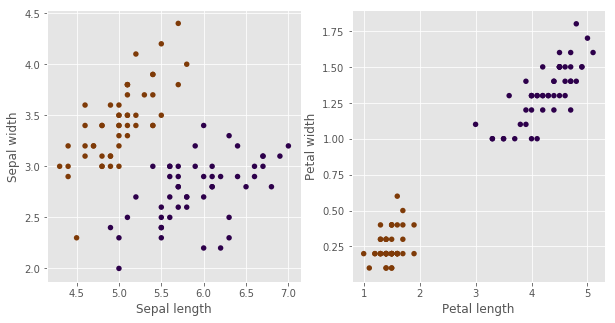

In [518]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [519]:
# Давайте проверим, как справляются sklearn реализации
sklearn_gmm = GaussianMixture(n_components=2)
gmm_t0 = time.time()
sklearn_gmm.fit(x_iris)
gmm_diff = time.time() - gmm_t0
gmm_score = smt.adjusted_rand_score(y_iris, sklearn_gmm.predict(x_iris))

sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("GMM score {}. GMM time {}. AGGL score {}. AGGL time {}".format(gmm_score, gmm_diff, aggl_score, aggl_diff))

GMM score 1.0. GMM time 0.004623889923095703. AGGL score 1.0. AGGL time 0.0008077621459960938


In [521]:
model = Clustering(n_components=2)
my_gmm_t0 = time.time()
model.fit(x_iris)
pred_iris = model.predict(x_iris)
my_gmm_diff = time.time() - my_gmm_t0
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 1.00


Сверьте Ваш алгоритм с этими числами. Уверен, что у Вас получится не хуже!

# Боевое применение (2  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для анализа реальной задачи!

Важное замечание: в этой части задания студенту самому предлагается разобраться с данными и их форматом в качестве полезного упраженения. Не принимайте это близко к сердцу :)

Ввозьмем датасет различных стран.  
Данные нужно скачать тут https://data.worldbank.org/data-catalog/world-development-indicators.   


Подход следующий: фиксируем год, для каждой страны берём индикаторы по зафиксированному году, кластеризуем по индикаторам. 
Разбиение должно быть объяснимым, в противном случае, скорее всего нужно лучше настроить параметры кластеризации.   

Необходимо показать, какие страны попали в общий кластер в и объяснить из-за каких признаков это произошло. Если страны были в одном кластере, а спустя несколько лет разъехались по разным кластерам, попробуйте это объяснить. 

In [522]:
# Место для Вашего кластерного анализа

## 2010

In [642]:
df = pd.read_csv('WDIData.csv')
data = df[['Country Name','Indicator Name','2010']]
data = data.dropna(axis= 0)

dframe = data['2010'].groupby([data['Country Name'],data['Indicator Name']]).sum().unstack()
for frame in dframe.columns: 
    dframe[frame].fillna(dframe[frame].mean(), inplace = True)

Country_name = np.array(list(dframe.axes[0]))
Array = np.array(dframe)

In [654]:
from sklearn.manifold import TSNE
Array_embedded = TSNE(n_components= 2).fit_transform(Array)

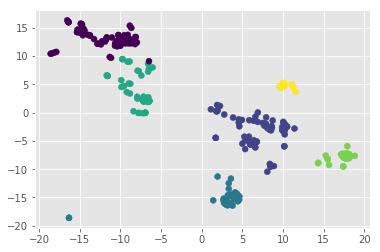

In [659]:
model = GaussianMixture(n_components=6)
model.fit(Array_embedded)
y_Array = model.predict(Array_embedded)

plt.scatter(Array_embedded[:, 0], Array_embedded[:, 1], c = y_Array)

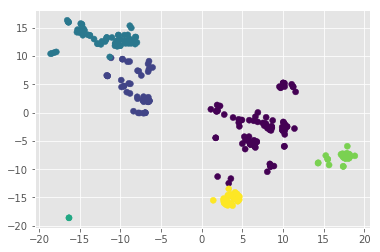

In [661]:
model = Clustering(n_components=6, max_iter=100)
model.fit(Array_embedded)
y_Array = model.predict(Array_embedded)

plt.scatter(Array_embedded[:, 0], Array_embedded[:, 1], c = y_Array)

In [662]:
Country_clusters = [[] for i in range(len(set(y_Array)))]
for i in range(len(y_Array)):
    Country_clusters[y_Array[i]].append(Country_name[i])

In [663]:
res_2010 = pd.DataFrame(Country_clusters).T
res_2010.T.values

array([['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
        'Armenia', 'Bangladesh', 'Benin', 'Bolivia',
        'Bosnia and Herzegovina', 'Brazil', 'Brunei Darussalam',
        'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia',
        'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
        'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire",
        'Croatia', 'Czech Republic', 'Denmark', 'Dominican Republic',
        'Ecuador', 'Egypt, Arab Rep.', 'Equatorial Guinea', 'Eritrea',
        'Gabon', 'Gambia, The', 'Ghana', 'Guinea', 'Guinea-Bissau',
        'Haiti', 'Honduras', 'Hong Kong SAR, China', 'Hungary', 'Israel',
        'Jordan', 'Kazakhstan', 'Kenya', 'Kosovo', 'Kuwait',
        'Kyrgyz Republic', 'Lesotho', 'Liberia', 'Macao SAR, China',
        'Macedonia, FYR', 'Madagascar', 'Malaysia', 'Mali', 'Mauritania',
        'Mexico', 'Mongolia', 'Montenegro', 'Mozambique', 'Nicaragua',
        'Niger', 'Nigeria', 'Norway', 'Pak

## 2000

In [347]:
df = pd.read_csv('WDIData.csv')
data = df[['Country Name','Indicator Name','2000']]
data = data.dropna(axis= 0)

dframe = data['2000'].groupby([data['Country Name'],data['Indicator Name']]).sum().unstack()
for frame in dframe.columns: 
    dframe[frame].fillna(dframe[frame].mean(), inplace = True)

Country_name = np.array(list(dframe.axes[0]))
Array = np.array(dframe)

In [359]:
from sklearn.manifold import TSNE
Array_embedded = TSNE(n_components= 2).fit_transform(Array)
#plt.scatter(Array_embedded[:, 0], Array_embedded[:, 1])

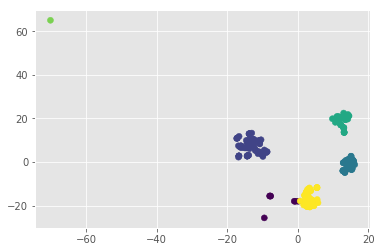

In [370]:
model = GaussianMixture(n_components=6)
model.fit(Array_embedded)
y_Array = model.predict(Array_embedded)

plt.scatter(Array_embedded[:, 0], Array_embedded[:, 1], c = y_Array)

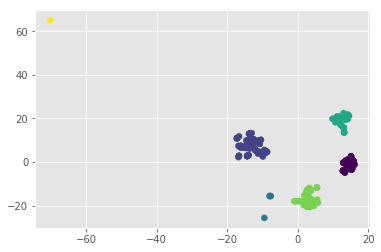

In [367]:
model = Clustering(n_components=6, max_iter=100)
model.fit(Array_embedded)
y_Array = model.predict(Array_embedded)

plt.scatter(Array_embedded[:, 0], Array_embedded[:, 1], c = y_Array)

In [372]:
Country_clusters = [[] for i in range(len(set(y_Array)))]
for i in range(len(y_Array)):
    Country_clusters[y_Array[i]].append(Country_name[i])

In [375]:
res_2000 = pd.DataFrame(Country_clusters).T
res_2000.T.values

array([['Chile', 'Colombia', 'Djibouti', 'Iran, Islamic Rep.', 'Iraq',
        'Japan', 'Korea, Rep.', 'Vietnam', None, None, None, None, None,
        None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, None, None, None, None, None, None,
        None],
       ['Algeria', 'Angola', 'Argentina', 'Armenia', 'Australia',
        'Azerbaijan', 'Bahamas, The', 'Belarus', 'Belize', 'Benin',
        'Bhutan', 'Bolivia', 'Botswana', 'Burkina Faso', 'Burundi',
        'Cambodia', 'Cameroon', 'Chad', 'China', 'Comoros',
        'Congo, Dem. Rep.', 'Congo, Rep.', 'Croatia', 'Cuba',

## 1990

In [461]:
df = pd.read_csv('WDIData.csv')
data = df[['Country Name','Indicator Name','1990']]
data = data.dropna(axis= 0)

dframe = data['1990'].groupby([data['Country Name'],data['Indicator Name']]).sum().unstack()
for frame in dframe.columns: 
    dframe[frame].fillna(dframe[frame].mean(), inplace = True)

Country_name = np.array(list(dframe.axes[0]))
Array = np.array(dframe)

In [464]:
from sklearn.manifold import TSNE
Array_embedded = TSNE(n_components= 2).fit_transform(Array)
#plt.scatter(Array_embedded[:, 0], Array_embedded[:, 1])

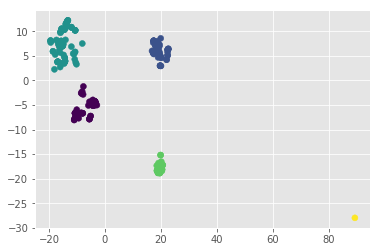

In [472]:
model = GaussianMixture(n_components=5)
model.fit(Array_embedded)
y_Array = model.predict(Array_embedded)

plt.scatter(Array_embedded[:, 0], Array_embedded[:, 1], c = y_Array)

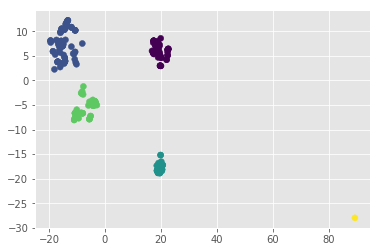

In [473]:
model = Clustering(n_components=5, max_iter=100)
model.fit(Array_embedded)
y_Array = model.predict(Array_embedded)

plt.scatter(Array_embedded[:, 0], Array_embedded[:, 1], c = y_Array)

In [477]:
Country_clusters = [[] for i in range(len(set(y_Array)))]
for i in range(len(y_Array)):
    Country_clusters[y_Array[i]].append(Country_name[i])

In [478]:
res_1990 = pd.DataFrame(Country_clusters).T
res_1990.T.values

array([['Algeria', 'Argentina', 'Armenia', 'Australia', 'Bahamas, The',
        'Belarus', 'Belize', 'Benin', 'Bolivia', 'Botswana',
        'Brunei Darussalam', 'Burkina Faso', 'Cameroon', 'China',
        'Comoros', 'Congo, Rep.', 'Cuba', 'Cyprus', 'Dominican Republic',
        'Ecuador', 'El Salvador', 'Equatorial Guinea', 'Gabon',
        'Guatemala', 'Honduras', 'Hong Kong SAR, China', 'India',
        'Jordan', 'Kazakhstan', 'Kenya', 'Kyrgyz Republic', 'Lesotho',
        'Macao SAR, China', 'Macedonia, FYR', 'Madagascar', 'Malaysia',
        'Mali', 'Mauritius', 'Mexico', 'Morocco', 'Namibia', 'Nigeria',
        'Pakistan', 'Panama', 'Papua New Guinea', 'Peru', 'Philippines',
        'Poland', 'Puerto Rico', 'Senegal', 'Seychelles', 'Singapore',
        'South Africa', 'Sri Lanka', 'Syrian Arab Republic', 'Tanzania',
        'Thailand', 'Togo', 'Turkey', 'Ukraine', 'United States',
        'Uruguay', 'Venezuela, RB', None, None, None, None, None, None,
        None, None, None, N

In [ ]:
# Не переживайте, мне тоже было тяжело разобраться с данными

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему алгоритмов кластеризации и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите, пожалуйста, для каких прикладных задач Вы бы стали использовать методы кластеризации?

***Ваше ответ здесь***

Для задач где необходимо найти кластерную структуру в данных, как-то разбить группы объектов на кластера, сгруппировать какие-то объекты. Также можно обнаружить какие-то особенные объекты (выбросы), которые не принадлежат ни одному кластеру. Также если у нас много данных, например, большая группа пользователей, мы можем объединить их в группы и характеризовать пользователя в группе по "среднему пользователю" из этой же группы, таким образом мы сожмем наши данные о пользователях.

* Какие преимущества и недостатки Вы видите у следуюших алгоритмов кластеризации: kmeans, dbscan, агломеративная кластеризация?

***Ваше ответ здесь***


***Dbscan:***

- Способен выделять кластеры произвольной формы
- Не требуется задания числа кластеров, автоматичеки определяет их количество
- Учитывает выбросы в данных
- Плохо работает при различных плотностях кластеров
- Неспособность соединять кластеры через небольший проёмы, а также связывает явно различные кластеры через плотно населённые перемычки 


***Агломеративная кластеризация:***

- Способен выделять кластеры произвольной формы
- Разнообразие критериев
- Любые K из коробки, т.е. после выполнения алгоритма, мы сами можем выбрать требуемое количество кластеров.
- Очень наглядный алгоритм (дендрограмма)
- Требует много ресурсов

***K-means:***

- Вычислительно недорог
- Прост в реализации
- Имеет множество модификаций
- Интерпретация кластеров через центройды
- В результате получеются "сферические" кластеры что не всегда соответствует реальности



* На лекции было показано, что EM алгоритм находит оценку максимального правдоподобия в задаче со скрытыми переменными. Из курса мат. статистики Вы можете знать, оценка максимального правдоподобия "оптимальная" во многих смыслах. В каких же случаях тогда не следует применять метод максимального правдоподобия?

***Ваше ответ здесь***  
Если правдоподие ограничено, то EM алгоритм сходится к стационарной точке. Получается, что мы можем сойтись к локальному минимуму вместо глобального. Получается, что в этом случае не следует использовать метод максимального правдоподобия. Также метод максимального правдоподобия не гарантирует несмещенность оценок. 


* Многие алгоритмы анализа данных страдают "проклятием" размерности. Страдают ли этим проклятием алгоритмы кластеризации? Если да, то как бы Вы с этим боролись?

***Ваше ответ здесь***

Да, страдают. Методы борьбы с проклятием размерности: PCA, t-SNE, отбор признаков.

* Представьте, что у Вас есть набор текстовых документов, и Вы хотите разбить эти документы на тематики - новости, спорт, кулинария, кино и так далее. Размеченной выборки у Вас нет, только сами тексты документов. Какие алгоритмы и какие признаки Вы бы использовали для решения данной задачи?

***Ваше ответ здесь***

Для начала я бы сделал токенизацию, потом провел нормализацию(лемматизация), далее осуществил бы грамматический разбор, в том плане, что оставил бы только существительные из текста (на лекциях было сказано, что это строится на основе размеченного корпуса текста или с помощью эвристик). Далее я бы использовал простой bag of words, так как нам скорее всего не нужно знать порядок слов, ведь тематики определяются особыми, специальными словами, конечно, можно бы использовать представления слов с помощью Word2Vec, но думаю bag of words тоже неплохо сработает. Далее бы провел кластеризацию, думаю здесь лучше использовать агломеративные алгоритмы.

* Теперь представьте, что небольшая часть Ваших текстов была размечена людьми, но большая часть так и осталась без таргета. Смогли ли бы Вы использовать эти данные для улучения качества кластеризации? (эта задача называется semi-supervised learning)

***Ваше ответ здесь***  
Для метода который я выбрал, а именно использование агломеративных алгоритмов, это никак скорее всего не поможет, но если бы я использовал Gaussian Mixture Model, или k-means, то можно былос помощью уже размеченных данных задать начальные параметры для этих кластеров.

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***

Данные для данной задачи имеют слишком много пропусков, возможно, стоит предложить какую-нибудь более интересную задачу.